### Imports

In [1]:
import pandas as pd
import numpy as np
import pickle as pk
import requests
import copy
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats.mstats import winsorize
from sklearn.linear_model import LinearRegression

### Data collection

In [2]:
df = pd.read_parquet("df_all_features.pq")

In [3]:
# # =============================
# # ListNet Listwise LTR 
# # + Long/Short backtest + Sharpe + stable cumulative plots
# # =============================

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# from typing import List
# from collections import defaultdict

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader


# # -----------------------------
# # 0) CONFIG 
# # -----------------------------
# # Target used to TRAIN the ranker 
# target_col = "close_1d_ret_hedged_normalised"

# # Return used for BACKTEST evaluation (raw realized return)
# realized_ret_col = "close_1d_ret"

# # Portfolio size for long/short backtest
# TOP_K = 35

# # Train/test split by time (80% train, 20% test)
# TRAIN_FRAC = 0.80

# # Training hyperparameters
# EPOCHS = 8
# LR = 1e-3
# BATCH_SIZE = 16

# # Repro + device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch.manual_seed(0)
# np.random.seed(0)


# # -----------------------------
# # 1) SAFETY: keep only numeric features
# # -----------------------------
# def filter_numeric_features(df: pd.DataFrame, feature_cols: List[str]) -> List[str]:
#     """
#     Keeps only columns in feature_cols that are present in df AND numeric.
#     This prevents errors like: "could not convert string to float: 'CL'".
#     """
#     keep = []
#     dropped = []
#     for c in feature_cols:
#         if c not in df.columns:
#             dropped.append((c, "missing"))
#             continue
#         if pd.api.types.is_numeric_dtype(df[c]):
#             keep.append(c)
#         else:
#             dropped.append((c, str(df[c].dtype)))
#     print(f"[Feature filter] kept={len(keep)} dropped={len(dropped)}")
#     if dropped:
#         print("[Feature filter] examples dropped:", dropped[:10], "..." if len(dropped) > 10 else "")
#     return keep


# # -----------------------------
# # 2) Build query lists: group by Date (index)
# # -----------------------------
# def make_query_lists(
#     df_in: pd.DataFrame,
#     feature_cols: List[str],
#     target_col: str,
#     realized_ret_col: str
# ):
#     """
#     Turns the dataframe into a list of "queries" for listwise LTR.

#     Each query corresponds to one date (one ranking list):
#       - Xq: (N_assets, n_features) features
#       - yq: (N_assets,) training labels used to learn ranking
#       - rq: (N_assets,) realized returns used ONLY for evaluation/backtest
#       - date: the query identifier

#     Important:
#     - We drop rows with NaN in required columns so tensors are valid.
#     - We skip dates with <2 assets because listwise ranking is meaningless with 1 item.
#     """
#     queries = []
#     # Since Date is a simple index (not MultiIndex), group by df_in.index is safest.
#     for date, g in df_in.groupby(df_in.index):
#         g = g.dropna(subset=feature_cols + [target_col, realized_ret_col])
#         if len(g) < 2:
#             continue

#         Xq = g[feature_cols].to_numpy(dtype=np.float32)
#         yq = g[target_col].to_numpy(dtype=np.float32)
#         rq = g[realized_ret_col].to_numpy(dtype=np.float32)

#         queries.append((Xq, yq, rq, date))
#     return queries


# # -----------------------------
# # 3) Dataset + collate for variable-length lists
# # -----------------------------
# class QueryDataset(Dataset):
#     """
#     Minimal dataset: each item is already one query tuple (Xq, yq, rq, date).
#     Queries have variable number of assets, so we do NOT stack/pad them here.
#     """
#     def __init__(self, queries):
#         self.queries = queries

#     def __len__(self):
#         return len(self.queries)

#     def __getitem__(self, idx):
#         return self.queries[idx]


# def collate_queries(batch):
#     """
#     Custom collate function: keep the batch as a list of variable-length queries.
#     That means each batch is a Python list of tuples, not a big padded tensor.
#     """
#     return batch


# # -----------------------------
# # 4) ListNet model
# # -----------------------------
# class ListNetMLP(nn.Module):
#     """
#     Simple scoring model:
#     input: features of one asset
#     output: a single scalar score
#     Ranking within a date is obtained by sorting these scores descending.
#     """
#     def __init__(self, d_in: int, hidden: int = 128):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(d_in, hidden),
#             nn.ReLU(),
#             nn.Linear(hidden, hidden),
#             nn.ReLU(),
#             nn.Linear(hidden, 1)
#         )

#     def forward(self, x):
#         # x: (N_assets, d_in) -> returns scores: (N_assets,)
#         return self.net(x).squeeze(-1)


# def listnet_loss(scores: torch.Tensor, labels: torch.Tensor):
#     """
#     Classic ListNet loss:
#       p_true = softmax(labels)    (distribution induced by labels)
#       p_pred = softmax(scores)    (distribution induced by predicted scores)
#     ListNet optimizes cross-entropy:  - sum p_true * log(p_pred)

#     Stability tweaks:
#     - subtract max from labels before softmax to reduce overflow
#     - use log_softmax(scores) (numerically stable)
#     """
#     labels = labels - labels.max()          # stabilizes exp in softmax
#     p_true = F.softmax(labels, dim=0)
#     log_p_pred = F.log_softmax(scores, dim=0)
#     return -(p_true * log_p_pred).sum()


# # -----------------------------
# # 5) Return conversion helpers + sharpe + stable cumprod
# # -----------------------------
# def bps_to_decimal(r: pd.Series) -> pd.Series:
#     """Convert basis points to decimal returns, e.g. 25 bps -> 0.0025."""
#     return r.astype(float) / 10000.0


# def sharpe_ratio(daily_ret: pd.Series, periods_per_year=252):
#     """
#     Annualized Sharpe ratio (no risk-free rate here):
#       Sharpe = mean(ret) / std(ret) * sqrt(252)
#     """
#     daily_ret = daily_ret.dropna()
#     if len(daily_ret) < 2:
#         return np.nan
#     mu = daily_ret.mean()
#     sigma = daily_ret.std(ddof=1)
#     if sigma == 0 or np.isnan(sigma):
#         return np.nan
#     return (mu / sigma) * np.sqrt(periods_per_year)


# def stable_cumprod(daily_ret: pd.Series):
#     """
#     Stable cumulative performance curve:
#     cumprod(1+r) can overflow if r has extreme values.
#     Use: exp(cumsum(log1p(r))) for numerical stability.
#     """
#     r = daily_ret.fillna(0.0).clip(lower=-0.99)
#     return np.exp(np.log1p(r).cumsum())


# # -----------------------------
# # 6) Train + predict per query
# # -----------------------------
# def train_listnet(train_queries, feature_dim, epochs=8, lr=1e-3, batch_size=16):
#     """
#     Training loop:
#     - Each batch is a list of queries (variable sizes).
#     - For each query: compute scores and ListNet loss.
#     - Average loss over queries in the batch, backprop, optimizer step.

#     Small robustness improvements:
#     - Skip NaN/Inf loss batches
#     - Gradient clipping to prevent exploding gradients
#     """
#     model = ListNetMLP(feature_dim, hidden=128).to(device)
#     opt = torch.optim.Adam(model.parameters(), lr=lr)

#     loader = DataLoader(
#         QueryDataset(train_queries),
#         batch_size=batch_size,
#         shuffle=True,
#         collate_fn=collate_queries
#     )

#     for ep in range(1, epochs + 1):
#         model.train()
#         losses = []

#         for batch in loader:
#             opt.zero_grad()
#             batch_loss = 0.0

#             # Each element in batch is one query: (Xq, yq, rq, date)
#             for Xq, yq, rq, date in batch:
#                 X = torch.tensor(Xq, device=device)
#                 y = torch.tensor(yq, device=device)

#                 scores = model(X)
#                 loss = listnet_loss(scores, y)
#                 batch_loss = batch_loss + loss

#             batch_loss = batch_loss / len(batch)

#             # Safety check: avoid training on NaN
#             if not torch.isfinite(batch_loss):
#                 print("Warning: non-finite loss encountered. Skipping this batch.")
#                 continue

#             batch_loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
#             opt.step()

#             losses.append(batch_loss.item())

#         print(f"Epoch {ep}/{epochs} - loss={np.mean(losses):.6f}")

#     return model


# def predict_scores(model, queries):
#     """
#     Runs the trained model on each query and returns:
#       (date, scores_np, realized_np)

#     scores_np is used for ranking; realized_np is used for backtest.
#     """
#     model.eval()
#     out = []
#     with torch.no_grad():
#         for Xq, yq, rq, date in queries:
#             X = torch.tensor(Xq, device=device)
#             scores = model(X).detach().cpu().numpy()
#             out.append((date, scores, rq))
#     return out


# # -----------------------------
# # 7) Evaluation: long/short + bucket plot + best/worst CG day
# # -----------------------------
# def evaluate_and_plot(pred_list, top_k=35, title_prefix="ListNet"):
#     """
#     pred_list: list of (date, scores, realized_raw)

#     Steps:
#     1) For each day:
#        - sort by model score
#        - long = mean return of top K
#        - short = mean return of bottom K
#        - long-short = long - short
#     2) Plot cumulative curves (stable) and compute Sharpe ratios.
#     3) Bucket analysis: deciles of scores -> average realized return per bucket.
#     4) Cumulative Gain curve: cumsum of realized returns sorted by score for best/worst day.
#     """
#     daily_rows = []
#     bucket_rows = []

#     for date, scores, realized_raw in pred_list:
#         realized = realized_raw.astype(float) / 10000.0  # assume bps -> decimal

#         dfq = pd.DataFrame({"score": scores, "ret": realized}).dropna()
#         if len(dfq) < 2:
#             continue

#         dfq = dfq.sort_values("score", ascending=False)
#         k = min(top_k, len(dfq) // 2)  # safety: need both long & short

#         long_ret = dfq.head(k)["ret"].mean()
#         short_ret = dfq.tail(k)["ret"].mean()
#         ls_ret = long_ret - short_ret
#         daily_rows.append((date, long_ret, short_ret, ls_ret))

#         # Bucket analysis (deciles)
#         dfq["bucket"] = pd.qcut(dfq["score"], 10, labels=False, duplicates="drop")
#         bucket_mean = dfq.groupby("bucket")["ret"].mean()
#         for b, v in bucket_mean.items():
#             bucket_rows.append((date, int(b), float(v)))

#     daily_df = pd.DataFrame(daily_rows, columns=["date", "long", "short", "long_short"]).set_index("date").sort_index()
#     if daily_df.empty:
#         print("No daily rows to evaluate.")
#         return

#     daily_df["cum_long"] = stable_cumprod(daily_df["long"])
#     daily_df["cum_short"] = stable_cumprod(daily_df["short"])
#     daily_df["cum_ls"] = stable_cumprod(daily_df["long_short"])

#     sharpe_long = sharpe_ratio(daily_df["long"])
#     sharpe_short = sharpe_ratio(daily_df["short"])
#     sharpe_ls = sharpe_ratio(daily_df["long_short"])

#     print("Sharpe (annualized):")
#     print("  Long:", sharpe_long)
#     print("  Short:", sharpe_short)
#     print("  Long-Short:", sharpe_ls)

#     # Plot 1: Long-Short cumulative
#     plt.figure()
#     plt.plot(daily_df.index, daily_df["cum_ls"])
#     plt.title(f"{title_prefix} Long-Short Cumulative Return (Top/Bottom {top_k})")
#     plt.xlabel("Date")
#     plt.ylabel("Cumulative (stable)")
#     plt.grid(True)
#     plt.show()

#     # Plot 2: Long vs Short cumulative
#     plt.figure()
#     plt.plot(daily_df.index, daily_df["cum_long"], label="Long")
#     plt.plot(daily_df.index, daily_df["cum_short"], label="Short")
#     plt.title(f"{title_prefix} Long vs Short Cumulative Returns")
#     plt.xlabel("Date")
#     plt.ylabel("Cumulative (stable)")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     # Plot 3: average bucket returns over test
#     bucket_df = pd.DataFrame(bucket_rows, columns=["date", "bucket", "ret"])
#     if not bucket_df.empty:
#         avg_bucket = bucket_df.groupby("bucket")["ret"].mean()
#         plt.figure()
#         plt.bar(avg_bucket.index.astype(str), avg_bucket.values)
#         plt.title("Average Realized Return by Score Bucket (test)")
#         plt.xlabel("bucket")
#         plt.ylabel("avg daily return (decimal)")
#         plt.grid(True, axis="y")
#         plt.show()

#     # Plot 4: Cumulative Gain curve (best vs worst day)
#     best_day = None
#     worst_day = None
#     best_val = -np.inf
#     worst_val = np.inf

#     for date, scores, realized_raw in pred_list:
#         realized = realized_raw.astype(float) / 10000.0
#         dfq = pd.DataFrame({"score": scores, "ret": realized}).dropna()
#         if len(dfq) < 10:
#             continue

#         dfq = dfq.sort_values("score", ascending=False)
#         cg_curve = dfq["ret"].cumsum().values
#         final_cg = cg_curve[-1]

#         if final_cg > best_val:
#             best_val = final_cg
#             best_day = (date, cg_curve)
#         if final_cg < worst_val:
#             worst_val = final_cg
#             worst_day = (date, cg_curve)

#     if best_day and worst_day:
#         date_best, cg_best = best_day
#         date_worst, cg_worst = worst_day

#         # random baseline from best day (shuffle realized returns)
#         for date, scores, realized_raw in pred_list:
#             if date == date_best:
#                 realized = realized_raw.astype(float) / 10000.0
#                 dfq = pd.DataFrame({"score": scores, "ret": realized}).dropna()
#                 break
#         rnd = dfq.sample(frac=1.0, random_state=0)["ret"].cumsum().values

#         plt.figure()
#         plt.plot(cg_best, label=f"Best day {date_best} (ranked)")
#         plt.plot(cg_worst, label=f"Worst day {date_worst} (ranked)")
#         plt.plot(rnd, "--", label="Random baseline (best day shuffled)")
#         plt.title("Cumulative Gain Curve (single day)")
#         plt.xlabel("Rank position")
#         plt.ylabel("Cumulative sum of realized returns (decimal)")
#         plt.legend()
#         plt.grid(True)
#         plt.show()


# # -----------------------------
# # 8) CLEANER RUN PIPELINE (reorganized)
# # -----------------------------

# # --- A) Sort by date index and split train/test chronologically ---
# df = df.sort_index()
# unique_dates = df.index.unique().sort_values()
# split_idx = int(len(unique_dates) * TRAIN_FRAC)
# split_date = unique_dates[split_idx]

# df_train = df[df.index < split_date].copy()
# df_test  = df[df.index >= split_date].copy()

# print("\n--- 1) Time Split ---")
# print(f"Split date: {split_date}")
# print(f"Train rows: {len(df_train)} | Test rows: {len(df_test)}")

# # --- B) Define which columns to exclude from features ---
# # (Targets / IDs / obvious leakage / non-numeric identifiers)
# exclude_cols = {
#     target_col,
#     realized_ret_col,
#     "Ticker",
#     "id",
#     "close_1d_ret_hedged",     # potential leakage / alternative target
#     "relevance",
#     "predicted_score"
# }

# # --- C) Build feature list: numeric-only and not excluded ---
# print("\n--- 2) Feature Selection (numeric-only) ---")
# candidate_cols = [c for c in df_train.columns if c not in exclude_cols]
# feature_cols = [c for c in candidate_cols if pd.api.types.is_numeric_dtype(df_train[c])]

# print(f"Numeric features kept: {len(feature_cols)}")

# # --- D) Clean NaN/Inf only on the required columns (features + target + realized) ---
# print("\n--- 3) Cleaning NaN/Inf ---")
# cols_needed = feature_cols + [target_col, realized_ret_col]

# df_train = df_train[cols_needed].replace([np.inf, -np.inf], np.nan).dropna()
# df_test  = df_test[cols_needed].replace([np.inf, -np.inf], np.nan).dropna()

# print(f"Train rows after clean: {len(df_train)} | Test rows after clean: {len(df_test)}")

# # --- E) Build queries (one query per date) ---
# print("\n--- 4) Build Queries ---")
# train_queries = make_query_lists(df_train, feature_cols, target_col, realized_ret_col)
# test_queries  = make_query_lists(df_test,  feature_cols, target_col, realized_ret_col)
# print(f"Train queries: {len(train_queries)} | Test queries: {len(test_queries)}")

# # --- F) Train ListNet ---
# print("\n--- 5) Train ListNet ---")
# model = train_listnet(
#     train_queries,
#     feature_dim=len(feature_cols),
#     epochs=EPOCHS,
#     lr=LR,
#     batch_size=BATCH_SIZE
# )

# # --- G) Predict on test queries ---
# print("\n--- 6) Score Test Queries ---")
# pred_list = predict_scores(model, test_queries)

# # --- H) Evaluate + plots ---
# print("\n--- 7) Evaluate & Plot ---")
# evaluate_and_plot(pred_list, top_k=TOP_K, title_prefix="ListNet")


--- 1. Split Temporel ---
Split Date: 2020-09-18 00:00:00
--- 2. Sélection Features (Correctif 'CL' string) ---
Features numériques retenues : 265
--- 3. Nettoyage NaN/Inf (Correctif 'Loss NaN') ---
Train rows: 1707536 | Test rows: 541430
--- 4. Création des Queries ---
Train queries: 4958 | Test queries: 1303
--- 5. Entraînement ---
Epoch 1/8 | Loss: 1132059.495505
Epoch 2/8 | Loss: 3977.017814
Epoch 3/8 | Loss: 30.901870
Epoch 4/8 | Loss: 17.971423
Epoch 5/8 | Loss: 6.926623
Epoch 6/8 | Loss: 11.919562
Epoch 7/8 | Loss: 12.829237
Epoch 8/8 | Loss: 7.258352
--- 6. Évaluation ---
Strategy Sharpe Ratio: 0.93
Mean IC: -0.0016


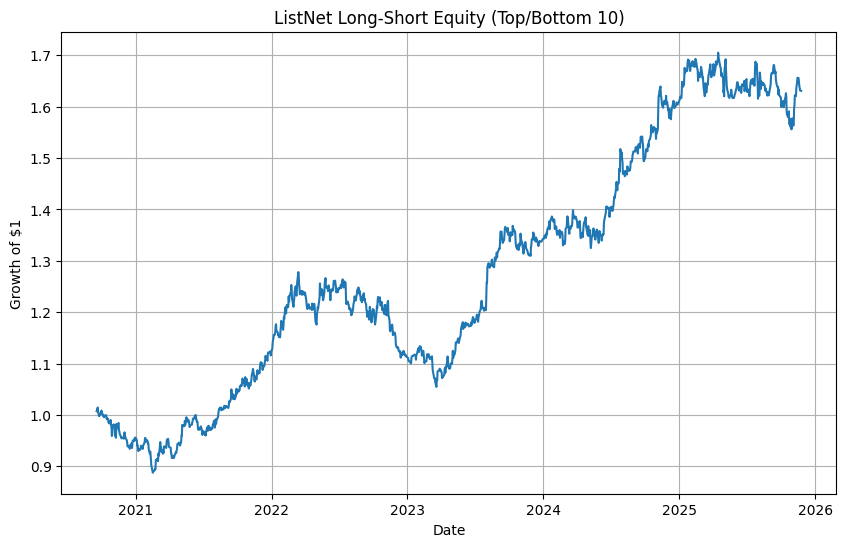

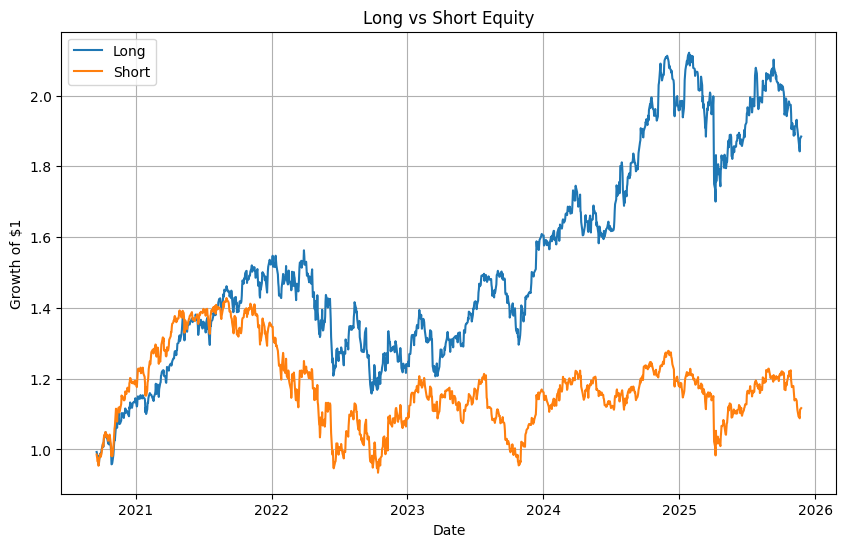

In [3]:
import numpy as np
import pandas as pd
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

# -----------------------------
# 0) Config
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

target_col = "close_1d_ret_hedged_normalised"  # target de ranking (stable)
realized_ret_col = "close_1d_ret"              # return "réalisé" pour backtest
TOPK = 10
EPOCHS = 8
LR = 1e-3
BATCH_SIZE = 64
TEMP = 1.0 

# -----------------------------
# 1) Helpers robustes (INTOUCHÉS)
# -----------------------------
def to_decimal_returns(r: np.ndarray) -> np.ndarray:
    """Heuristique: si ça ressemble à des bps, divise par 10000."""
    r = np.asarray(r, dtype=np.float64)
    med = np.nanmedian(np.abs(r))
    if med > 1.0:
        return r / 10000.0
    return r

def stable_equity_curve(daily_ret: pd.Series) -> pd.Series:
    """cumprod stable via log1p + clipping pour éviter overflow."""
    r = daily_ret.replace([np.inf, -np.inf], np.nan).fillna(0.0).astype(np.float64)
    r = r.clip(-0.99, 0.50)  # bornes "plot-safe"
    return np.exp(np.log1p(r).cumsum())

def sharpe_ratio(daily_ret: pd.Series, periods_per_year=252):
    r = daily_ret.replace([np.inf, -np.inf], np.nan).dropna()
    if len(r) < 2:
        return np.nan
    mu = r.mean()
    sigma = r.std(ddof=1)
    if sigma == 0 or np.isnan(sigma):
        return np.nan
    return (mu / sigma) * np.sqrt(periods_per_year)

def rank_ic(scores: np.ndarray, rets: np.ndarray):
    """Spearman = corr(ranks(scores), ranks(rets)). Renvoie np.nan si constant."""
    s = pd.Series(scores).rank(method="average").to_numpy()
    r = pd.Series(rets).rank(method="average").to_numpy()
    if np.std(s) == 0 or np.std(r) == 0:
        return np.nan
    return np.corrcoef(s, r)[0, 1]


# -----------------------------
# 2) Préparation features (INTOUCHÉ)
# -----------------------------
def get_feature_cols(df: pd.DataFrame, target_col: str, realized_ret_col: str):
    # On garde uniquement les colonnes numériques
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    drop_cols = [c for c in [target_col, realized_ret_col] if c in num_cols]
    feature_cols = [c for c in num_cols if c not in drop_cols]
    return feature_cols

def clean_targets(y: np.ndarray, clip=10.0):
    """
    Nettoyage ultra-important:
    - remplace NaN/inf
    - clip (évite softmax overflow)
    - standardise par query (mean=0,std=1) si std>0
    """
    y = np.asarray(y, dtype=np.float32)
    y = np.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)
    y = np.clip(y, -clip, clip)
    std = y.std()
    if std > 1e-6:
        y = (y - y.mean()) / std
    else:
        y = y - y.mean()
    return y.astype(np.float32)


# -----------------------------
# 3) Construction des queries par date (INTOUCHÉ)
# -----------------------------
def make_query_lists(df_in: pd.DataFrame, feature_cols, target_col):
    queries = []
    # Date est index simple
    for date, g in df_in.groupby(df_in.index):
        Xq = g[feature_cols].to_numpy(dtype=np.float32)
        yq = g[target_col].to_numpy(dtype=np.float32)
        yq = clean_targets(yq, clip=10.0)

        # skip queries trop petites
        if len(yq) < 2:
            continue
        queries.append((Xq, yq, date, g))
    return queries


# -----------------------------
# 4) Dataset + collate variable-length (INTOUCHÉ)
# -----------------------------
class QueryDataset(Dataset):
    def __init__(self, queries):
        self.queries = queries

    def __len__(self):
        return len(self.queries)

    def __getitem__(self, idx):
        Xq, yq, date, g = self.queries[idx]
        return Xq, yq, date

def collate_queries(batch):
    # batch = list of (Xq, yq, date)
    lengths = [b[0].shape[0] for b in batch]
    maxlen = max(lengths)
    d = batch[0][0].shape[1]

    Xpad = torch.zeros((len(batch), maxlen, d), dtype=torch.float32)
    ypad = torch.zeros((len(batch), maxlen), dtype=torch.float32)
    mask = torch.zeros((len(batch), maxlen), dtype=torch.bool)
    dates = []

    for i, (Xq, yq, date) in enumerate(batch):
        L = Xq.shape[0]
        Xpad[i, :L] = torch.from_numpy(Xq)
        ypad[i, :L] = torch.from_numpy(yq)
        mask[i, :L] = True
        dates.append(date)

    return Xpad, ypad, mask, dates


# -----------------------------
# 5) Modèle simple (INTOUCHÉ)
# -----------------------------
class RankMLP(nn.Module):
    def __init__(self, d_in, hidden=128, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 1)
        )

    def forward(self, X):
        # X: [B, L, d]
        out = self.net(X).squeeze(-1)  # [B, L]
        return out


# -----------------------------
# 6) ListNet loss (INTOUCHÉ)
# -----------------------------
def listnet_loss(scores, y_true, mask, temperature=1.0):
    neg_inf = torch.tensor(-1e9, device=scores.device, dtype=scores.dtype)
    scores_masked = torch.where(mask, scores, neg_inf)
    y_masked = torch.where(mask, y_true, neg_inf)

    # softmax stable: log_softmax pour scores (p_pred)
    log_p_pred = F.log_softmax(scores_masked / temperature, dim=1)

    # p_true = softmax(y_true) stable
    p_true = F.softmax(y_masked / temperature, dim=1)

    loss = -(p_true * log_p_pred).sum(dim=1)  # [B]
    return loss.mean()


# -----------------------------
# 7) Entrainement (INTOUCHÉ)
# -----------------------------
def train_listnet(train_loader, model, epochs=8, lr=1e-3):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(1, epochs + 1):
        losses = []
        for X, y, mask, _ in train_loader:
            X = X.to(device)
            y = y.to(device)
            mask = mask.to(device)

            opt.zero_grad()
            scores = model(X)

            loss = listnet_loss(scores, y, mask, temperature=TEMP)

            if not torch.isfinite(loss):
                continue

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            opt.step()
            losses.append(loss.item())

        avg = float(np.mean(losses)) if len(losses) else np.nan
        print(f"Epoch {epoch}/{epochs} | Loss: {avg:.6f}")

    return model


# -----------------------------
# 8) Scoring + backtest (INTOUCHÉ)
# -----------------------------
@torch.no_grad()
def score_queries(model, df_in: pd.DataFrame, feature_cols):
    model.eval()
    scored = []

    for date, g in df_in.groupby(df_in.index):
        X = g[feature_cols].to_numpy(dtype=np.float32)
        if X.shape[0] < 2:
            continue
        Xt = torch.from_numpy(X).to(device)
        scores = model(Xt).detach().cpu().numpy()
        tmp = g.copy()
        tmp["score"] = scores
        tmp["date"] = date
        scored.append(tmp)

    if not scored:
        return pd.DataFrame()
    return pd.concat(scored).sort_values(["date", "score"], ascending=[True, False])

def backtest_long_short(df_scored: pd.DataFrame, realized_ret_col: str, topk=10):
    daily = []
    for date, g in df_scored.groupby("date"):
        if len(g) < 2 * topk:
            continue

        rets_raw = g[realized_ret_col].to_numpy()
        rets = to_decimal_returns(rets_raw)

        g = g.copy()
        g["realized_dec"] = rets

        long_ret = g.head(topk)["realized_dec"].mean()
        short_ret = g.tail(topk)["realized_dec"].mean()
        ls_ret = long_ret - short_ret

        ls_ret = float(np.clip(ls_ret, -0.10, 0.10))
        long_ret = float(np.clip(long_ret, -0.10, 0.10))
        short_ret = float(np.clip(short_ret, -0.10, 0.10))

        daily.append((date, long_ret, short_ret, ls_ret))

    daily_df = pd.DataFrame(daily, columns=["date", "long", "short", "long_short"]).set_index("date").sort_index()
    return daily_df

def compute_daily_ic(df_scored: pd.DataFrame, realized_ret_col: str):
    ics = []
    for date, g in df_scored.groupby("date"):
        if len(g) < 5:
            continue
        rets = to_decimal_returns(g[realized_ret_col].to_numpy())
        ic = rank_ic(g["score"].to_numpy(), rets)
        ics.append(ic)
    if len(ics) == 0:
        return np.nan
    return float(np.nanmean(ics))


# -----------------------------
# 9) RUN (INTEGRATION DES AMELIORATIONS)
# -----------------------------

print("--- 1. Split Temporel ---")
df = df.sort_index()
dates = df.index.unique().sort_values()
split_idx = int(len(dates) * 0.80)
split_date = dates[split_idx]

df_train = df[df.index < split_date].copy()
df_test = df[df.index >= split_date].copy()
print(f"Split Date: {split_date}")

print("--- 2. Sélection Features (Correctif 'CL' string) ---")
# On définit explicitement les colonnes à bannir pour éviter le crash sur les strings
# (C'est la seule modification critique ajoutée)
exclude_cols = [
    target_col, 
    realized_ret_col, 
    'Ticker', 
    'id', 
    'close_1d_ret_hedged', # Leakage potentiel
    'relevance', 
    'predicted_score'
]

# On prend les numériques uniquement
feature_cols = [c for c in df_train.columns 
                if c not in exclude_cols 
                and pd.api.types.is_numeric_dtype(df_train[c])]

print(f"Features numériques retenues : {len(feature_cols)}")

print("--- 3. Nettoyage NaN/Inf (Correctif 'Loss NaN') ---")
cols_needed = feature_cols + [target_col, realized_ret_col]
df_train = df_train[cols_needed].replace([np.inf, -np.inf], np.nan).dropna()
df_test = df_test[cols_needed].replace([np.inf, -np.inf], np.nan).dropna()
print(f"Train rows: {len(df_train)} | Test rows: {len(df_test)}")

print("--- 4. Création des Queries ---")
train_queries = make_query_lists(df_train, feature_cols, target_col)
test_queries  = make_query_lists(df_test,  feature_cols, target_col)
print(f"Train queries: {len(train_queries)} | Test queries: {len(test_queries)}")

print("--- 5. Entraînement ---")
train_loader = DataLoader(QueryDataset(train_queries), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_queries)

d_in = len(feature_cols)
model = RankMLP(d_in=d_in, hidden=128, dropout=0.1).to(device)
model = train_listnet(train_loader, model, epochs=EPOCHS, lr=LR)

print("--- 6. Évaluation ---")
df_scored_test = score_queries(model, df_test, feature_cols)

daily_df = backtest_long_short(df_scored_test, realized_ret_col=realized_ret_col, topk=TOPK)
sr = sharpe_ratio(daily_df["long_short"])
ic_mean = compute_daily_ic(df_scored_test, realized_ret_col=realized_ret_col)

print(f"Strategy Sharpe Ratio: {sr:.2f}")
print(f"Mean IC: {ic_mean:.4f}")

# Equity curves
daily_df["cum_long"] = stable_equity_curve(daily_df["long"])
daily_df["cum_short"] = stable_equity_curve(daily_df["short"])
daily_df["cum_ls"] = stable_equity_curve(daily_df["long_short"])

plt.figure(figsize=(10, 6))
plt.plot(daily_df.index, daily_df["cum_ls"])
plt.title(f"ListNet Long-Short Equity (Top/Bottom {TOPK})")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(daily_df.index, daily_df["cum_long"], label="Long")
plt.plot(daily_df.index, daily_df["cum_short"], label="Short")
plt.legend()
plt.title("Long vs Short Equity")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.grid(True)
plt.show()

--- 1. Split Temporel ---
Split Date: 2020-09-18 00:00:00
--- 2. Sélection Features (Correctif 'CL' string) ---
Features numériques retenues : 265
--- 3. Nettoyage NaN/Inf (Correctif 'Loss NaN') ---
Train queries: 4958 Test queries: 1303
Epoch 1/8 - loss=865169.912834
Epoch 2/8 - loss=397908.068479
Epoch 3/8 - loss=229806.254480
Epoch 4/8 - loss=153980.508564
Epoch 5/8 - loss=68811.828367
Epoch 6/8 - loss=52041.455540
Epoch 7/8 - loss=46291.841943
Epoch 8/8 - loss=18430.845329
Sharpe (annualized):
  Long: 0.5210577503864765
  Short: 0.4359445896163349
  Long-Short: 0.3297314820686383


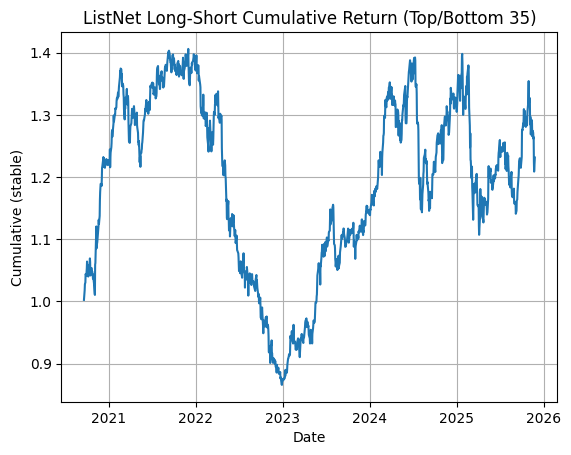

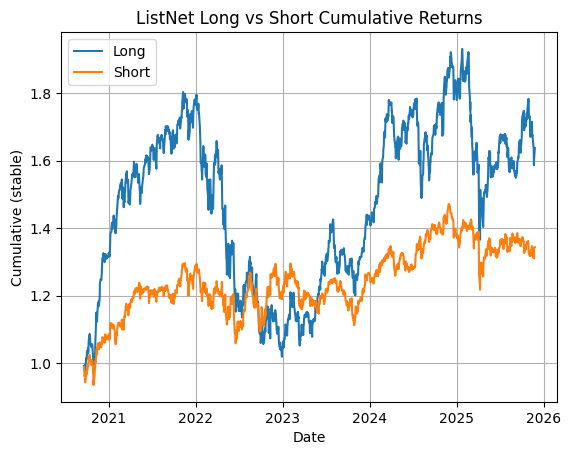

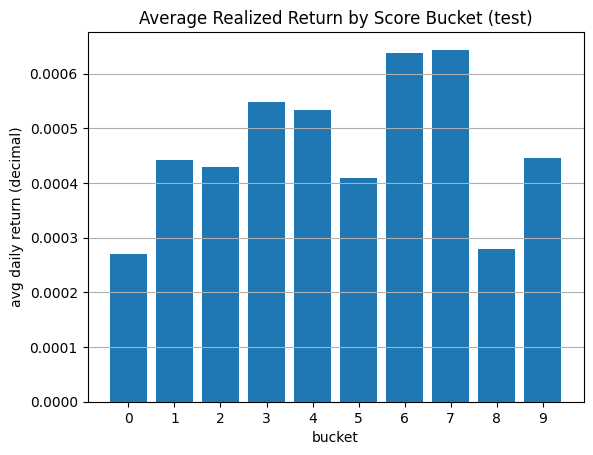

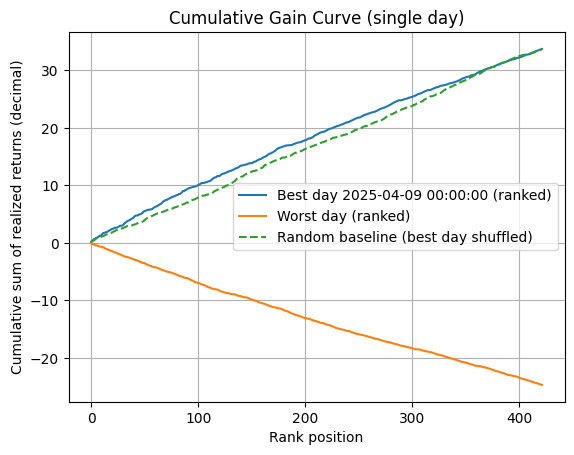

In [4]:
# =============================
# ListNet Listwise LTR (Version 1)
# + Long/Short backtest + Sharpe + stable cumulative plots
# =============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Tuple
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


# -----------------------------
# 0) CONFIG (à adapter)
# -----------------------------
target_col = "close_1d_ret_hedged_normalised"   # target pour apprendre à ranker
realized_ret_col = "close_1d_ret"              # return réalisé pour backtest (ici en bps)
TOP_K = 35

# Mets ici tes features candidates (ex: depuis ton notebook)
# feature_cols = [...]
# Si tu as déjà feature_cols défini avant, garde-le et laisse cette ligne commentée.
# feature_cols = all_features

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
np.random.seed(0)


# -----------------------------
# 1) SAFETY: keep only numeric features
# -----------------------------
def filter_numeric_features(df: pd.DataFrame, feature_cols: List[str]) -> List[str]:
    keep = []
    dropped = []
    for c in feature_cols:
        if c not in df.columns:
            dropped.append((c, "missing"))
            continue
        if pd.api.types.is_numeric_dtype(df[c]):
            keep.append(c)
        else:
            dropped.append((c, str(df[c].dtype)))
    print(f"[Feature filter] kept={len(keep)} dropped={len(dropped)}")
    if dropped:
        print("[Feature filter] examples dropped:", dropped[:10], "..." if len(dropped) > 10 else "")
    return keep


# -----------------------------
# 2) Build query lists: group by Date (index)
# -----------------------------
def make_query_lists(df_in: pd.DataFrame, feature_cols: List[str], target_col: str, realized_ret_col: str):
    """
    Returns list of queries: each item = (Xq, yq, rq, date)
    Xq: (N_assets, n_features)
    yq: (N_assets,) training target for ranking
    rq: (N_assets,) realized returns for evaluation (raw column)
    """
    queries = []
    for date, g in df_in.groupby(level=0):
        g = g.dropna(subset=feature_cols + [target_col, realized_ret_col])
        if len(g) < 2:
            continue
        Xq = g[feature_cols].to_numpy(dtype=np.float32)
        yq = g[target_col].to_numpy(dtype=np.float32)
        rq = g[realized_ret_col].to_numpy(dtype=np.float32)
        queries.append((Xq, yq, rq, date))
    return queries


# -----------------------------
# 3) Dataset + collate for variable-length lists
# -----------------------------
class QueryDataset(Dataset):
    def __init__(self, queries):
        self.queries = queries
    def __len__(self):
        return len(self.queries)
    def __getitem__(self, idx):
        return self.queries[idx]

def collate_queries(batch):
    # batch is list of tuples (Xq, yq, rq, date)
    return batch  # keep variable lengths


# -----------------------------
# 4) ListNet model
# -----------------------------
class ListNetMLP(nn.Module):
    def __init__(self, d_in: int, hidden: int = 128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, x):
        # x: (N, d_in)
        return self.net(x).squeeze(-1)  # (N,)


def listnet_loss(scores: torch.Tensor, labels: torch.Tensor):
    """
    Classic ListNet: cross-entropy between softmax(labels) and softmax(scores).
    labels: relevance (continuous ok), scores: predicted.
    """
    p_true = F.softmax(labels, dim=0)
    p_pred = F.log_softmax(scores, dim=0)
    return -(p_true * p_pred).sum()


# -----------------------------
# 5) Return conversion helpers + sharpe + stable cumprod
# -----------------------------
def bps_to_decimal(r: pd.Series) -> pd.Series:
    return r.astype(float) / 10000.0

def sharpe_ratio(daily_ret: pd.Series, periods_per_year=252):
    daily_ret = daily_ret.dropna()
    if len(daily_ret) < 2:
        return np.nan
    mu = daily_ret.mean()
    sigma = daily_ret.std(ddof=1)
    if sigma == 0:
        return np.nan
    return (mu / sigma) * np.sqrt(periods_per_year)

def stable_cumprod(daily_ret: pd.Series):
    # avoid overflow: exp(cumsum(log1p(r)))
    r = daily_ret.fillna(0.0).clip(lower=-0.99)
    return np.exp(np.log1p(r).cumsum())


# -----------------------------
# 6) Train + predict per query
# -----------------------------
def train_listnet(train_queries, feature_dim, epochs=8, lr=1e-3, batch_size=16):
    model = ListNetMLP(feature_dim, hidden=128).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    loader = DataLoader(QueryDataset(train_queries), batch_size=batch_size, shuffle=True, collate_fn=collate_queries)

    for ep in range(1, epochs+1):
        model.train()
        losses = []
        for batch in loader:
            opt.zero_grad()
            batch_loss = 0.0

            # each element is one query (variable length list)
            for Xq, yq, rq, date in batch:
                X = torch.tensor(Xq, device=device)
                y = torch.tensor(yq, device=device)

                scores = model(X)
                loss = listnet_loss(scores, y)
                batch_loss = batch_loss + loss

            batch_loss = batch_loss / len(batch)
            batch_loss.backward()
            opt.step()
            losses.append(batch_loss.item())

        print(f"Epoch {ep}/{epochs} - loss={np.mean(losses):.6f}")

    return model


def predict_scores(model, queries):
    """
    Returns: list of (date, scores_np, realized_np)
    """
    model.eval()
    out = []
    with torch.no_grad():
        for Xq, yq, rq, date in queries:
            X = torch.tensor(Xq, device=device)
            scores = model(X).detach().cpu().numpy()
            out.append((date, scores, rq))
    return out


# -----------------------------
# 7) Evaluation: long/short + bucket plot + best/worst CG day
# -----------------------------
def evaluate_and_plot(pred_list, top_k=35, title_prefix="ListNet"):
    """
    pred_list: list (date, scores, realized_raw)
    realized_raw here is in bps -> converted to decimal
    """

    daily_rows = []
    bucket_rows = []

    for date, scores, realized_raw in pred_list:
        # realized_raw are bps (given your stats) -> convert to decimal
        realized = realized_raw.astype(float) / 10000.0

        dfq = pd.DataFrame({"score": scores, "ret": realized}).dropna()
        if len(dfq) < 2:
            continue

        dfq = dfq.sort_values("score", ascending=False)
        k = min(top_k, len(dfq)//2)  # safety

        long_ret = dfq.head(k)["ret"].mean()
        short_ret = dfq.tail(k)["ret"].mean()
        ls_ret = long_ret - short_ret
        daily_rows.append((date, long_ret, short_ret, ls_ret))

        # bucket analysis (deciles)
        dfq["bucket"] = pd.qcut(dfq["score"], 10, labels=False, duplicates="drop")
        bucket_mean = dfq.groupby("bucket")["ret"].mean()
        for b, v in bucket_mean.items():
            bucket_rows.append((date, int(b), float(v)))

    daily_df = pd.DataFrame(daily_rows, columns=["date", "long", "short", "long_short"]).set_index("date").sort_index()
    if daily_df.empty:
        print("No daily rows to evaluate.")
        return

    daily_df["cum_long"] = stable_cumprod(daily_df["long"])
    daily_df["cum_short"] = stable_cumprod(daily_df["short"])
    daily_df["cum_ls"] = stable_cumprod(daily_df["long_short"])

    # Sharpe
    sharpe_long = sharpe_ratio(daily_df["long"])
    sharpe_short = sharpe_ratio(daily_df["short"])
    sharpe_ls = sharpe_ratio(daily_df["long_short"])

    print("Sharpe (annualized):")
    print("  Long:", sharpe_long)
    print("  Short:", sharpe_short)
    print("  Long-Short:", sharpe_ls)

    # ---- Plot 1: Long-Short cumulative ----
    plt.figure()
    plt.plot(daily_df.index, daily_df["cum_ls"])
    plt.title(f"{title_prefix} Long-Short Cumulative Return (Top/Bottom {top_k})")
    plt.xlabel("Date")
    plt.ylabel("Cumulative (stable)")
    plt.grid(True)
    plt.show()

    # ---- Plot 2: Long vs Short cumulative ----
    plt.figure()
    plt.plot(daily_df.index, daily_df["cum_long"], label="Long")
    plt.plot(daily_df.index, daily_df["cum_short"], label="Short")
    plt.title(f"{title_prefix} Long vs Short Cumulative Returns")
    plt.xlabel("Date")
    plt.ylabel("Cumulative (stable)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ---- Plot 3: bucket returns (average over test) ----
    bucket_df = pd.DataFrame(bucket_rows, columns=["date", "bucket", "ret"])
    if not bucket_df.empty:
        avg_bucket = bucket_df.groupby("bucket")["ret"].mean()
        plt.figure()
        plt.bar(avg_bucket.index.astype(str), avg_bucket.values)
        plt.title("Average Realized Return by Score Bucket (test)")
        plt.xlabel("bucket")
        plt.ylabel("avg daily return (decimal)")
        plt.grid(True, axis="y")
        plt.show()

    # ---- Plot 4: Cumulative Gain curve - best vs worst day ----
    # define "CG" as cumulative sum of realized returns after sorting by score (within day)
    best_day = None
    worst_day = None
    best_val = -np.inf
    worst_val = np.inf

    for date, scores, realized_raw in pred_list:
        realized = realized_raw.astype(float) / 10000.0
        dfq = pd.DataFrame({"score": scores, "ret": realized}).dropna()
        if len(dfq) < 10:
            continue
        dfq = dfq.sort_values("score", ascending=False)
        cg = dfq["ret"].cumsum().iloc[-1]  # total (end of curve)
        if cg > best_val:
            best_val = cg
            best_day = (date, dfq["ret"].cumsum().values)
        if cg < worst_val:
            worst_val = cg
            worst_day = (date, dfq["ret"].cumsum().values)

    if best_day and worst_day:
        # random baseline from best day
        date_best, cg_best = best_day
        _, cg_worst = worst_day

        # rebuild best day df to shuffle
        for date, scores, realized_raw in pred_list:
            if date == date_best:
                realized = realized_raw.astype(float) / 10000.0
                dfq = pd.DataFrame({"score": scores, "ret": realized}).dropna()
                break
        rnd = dfq.sample(frac=1.0, random_state=0)["ret"].cumsum().values

        plt.figure()
        plt.plot(cg_best, label=f"Best day {date_best} (ranked)")
        plt.plot(cg_worst, label=f"Worst day (ranked)")
        plt.plot(rnd, "--", label="Random baseline (best day shuffled)")
        plt.title("Cumulative Gain Curve (single day)")
        plt.xlabel("Rank position")
        plt.ylabel("Cumulative sum of realized returns (decimal)")
        plt.legend()
        plt.grid(True)
        plt.show()


# -----------------------------
# 8) RUN PIPELINE
# -----------------------------
print("--- 1. Split Temporel ---")
df = df.sort_index()
dates = df.index.unique().sort_values()
split_idx = int(len(dates) * 0.80)
split_date = dates[split_idx]

df_train = df[df.index < split_date].copy()
df_test = df[df.index >= split_date].copy()
print(f"Split Date: {split_date}")

print("--- 2. Sélection Features (Correctif 'CL' string) ---")
# On définit explicitement les colonnes à bannir pour éviter le crash sur les strings
# (C'est la seule modification critique ajoutée)
exclude_cols = [
    target_col, 
    realized_ret_col, 
    'Ticker', 
    'id', 
    'close_1d_ret_hedged', # Leakage potentiel
    'relevance', 
    'predicted_score'
]

# On prend les numériques uniquement
feature_cols = [c for c in df_train.columns 
                if c not in exclude_cols 
                and pd.api.types.is_numeric_dtype(df_train[c])]

print(f"Features numériques retenues : {len(feature_cols)}")

print("--- 3. Nettoyage NaN/Inf (Correctif 'Loss NaN') ---")
cols_needed = feature_cols + [target_col, realized_ret_col]
df_train = df_train[cols_needed].replace([np.inf, -np.inf], np.nan).dropna()
df_test = df_test[cols_needed].replace([np.inf, -np.inf], np.nan).dropna()

# Build query lists grouped by Date index
train_queries = make_query_lists(df_train, feature_cols, target_col, realized_ret_col)
test_queries  = make_query_lists(df_test,  feature_cols, target_col, realized_ret_col)

print("Train queries:", len(train_queries), "Test queries:", len(test_queries))

# Train ListNet
model = train_listnet(train_queries, feature_dim=len(feature_cols), epochs=8, lr=1e-3, batch_size=16)

# Predict scores on test
pred_list = predict_scores(model, test_queries)

# Evaluate + plots + Sharpe
evaluate_and_plot(pred_list, top_k=TOP_K, title_prefix="ListNet")
